# Library
berikut ini adalah library yang digunakan untuk mendeklarasikan segala macam library dari python untuk ekstrasi fitur yang diperlukan 

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.segmentation as seg
import pydicom
import os

# Function
fungsi2 ini untuk memunculkan fungsi showImage serta masking pada tahapan selanjutnya

In [2]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(9, 9))
  if ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

def masking(image):
    foreground_value = 255
    mask = np.uint8(image == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    image = np.zeros_like(image)
    image[labels == largest_label] = foreground_value
    ShowImage('masking',image,'rgb')

kita mengambil salah satu file untuk sample

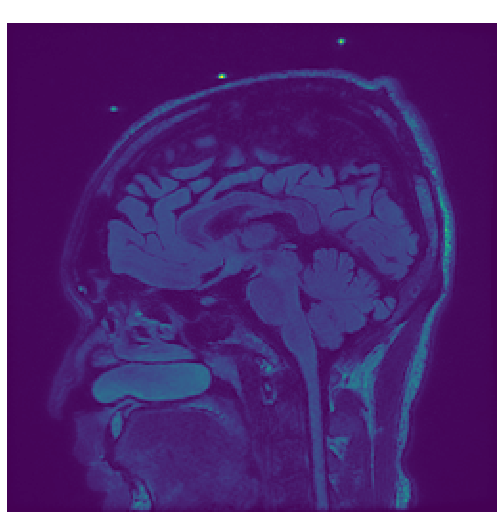

In [4]:
basepath ="C://Users//Asus//Desktop//tugas//RPLB (python)//Simple_Brain_MRI_Segmentation//dicom//"
d = pydicom.read_file(basepath + "Z108")
file = np.array(d.pixel_array)
img = file

img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

ShowImage('origin',hasil,'rgb')

# Otsu Thresholding
ini adalah satu dari banyak threshold, yang bisa digunakan, karena berdasarkan binary maka threshold ini banyak sekali diaplikasikan disetiap data.

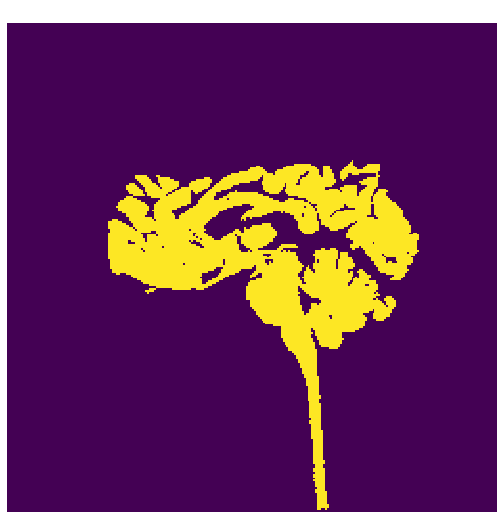

In [5]:
#OTSU THRESHOLDING
_,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

foreground_value = 255
mask = np.uint8(binarized == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
binarized = np.zeros_like(binarized)
binarized[labels == largest_label] = foreground_value
ShowImage('binarized',binarized,'rgb')

# Erosion from otsu
lalu proees erosi ini digunakan kami untuk menghasilkan salah morphology yaitu erosi, fungsinya untuk mengikis bagian tertentu dari gambar sesuai iterasi yang diberikan, bila diberikan banyak iterasi lebih banyak lagi yang terkikis.

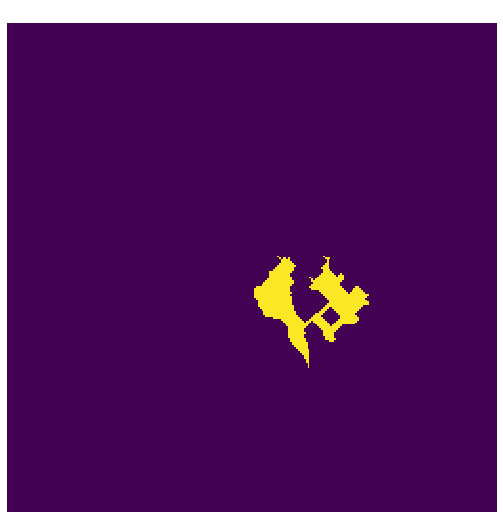

In [27]:
# kernel = np.ones((5, 5), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
erosion = cv2.erode(binarized,kernel,iterations = 4)

foreground_value = 255
mask = np.uint8(erosion == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
erosion = np.zeros_like(erosion)
erosion[labels == largest_label] = foreground_value

ShowImage('erosion',erosion,'rgb')

# Opening from erosion
fungsinya untuk membuka bagian dari titik gambar tertentu untuk didapatkan gambar yang diinginkan.

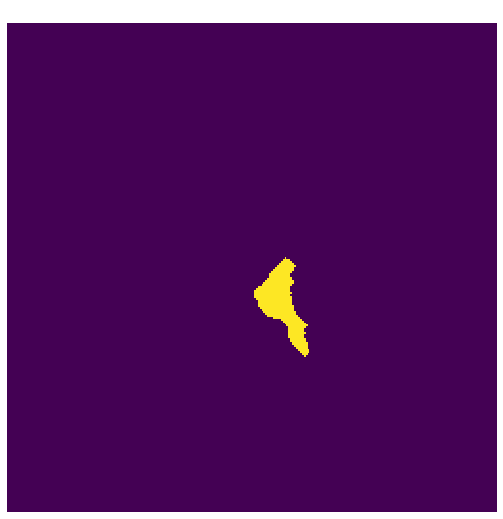

In [29]:
# kernel = np.ones((5, 5), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel, iterations= 2)

foreground_value = 255
mask = np.uint8(opening == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
opening = np.zeros_like(opening)
opening[labels == largest_label] = foreground_value

ShowImage('opening',opening,'rgb')

# Dilation from opening
sama halnya sebelumnya, fungsi ini, digunakan untuk proses selanjutnya untuk tahapan sebelumnya yaitu closing

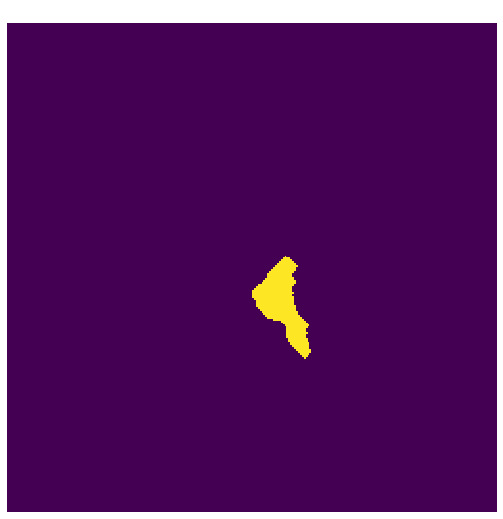

In [30]:
# bentukan = np.ones((5, 5), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
dilasi = cv2.dilate(opening,kernel,iterations = 1)

foreground_value = 255
mask = np.uint8(dilasi == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
dilasi = np.zeros_like(dilasi)
dilasi[labels == largest_label] = foreground_value
ShowImage('dilasi_akhir',dilasi,'rgb')

# Kmeans & Segmentation
fungsi ini untuk menghasilkan gabungan dari segmentasi awal hingga akhir, namun bagian tertentu saja yang kita inginkan. Misalkan hal ini dimulai dari hasil pertama kali (hasil) sampai dilasi open. lalu dilanjutkan kmeans untuk mendapatkan color quantization dalam gambar tersebut.

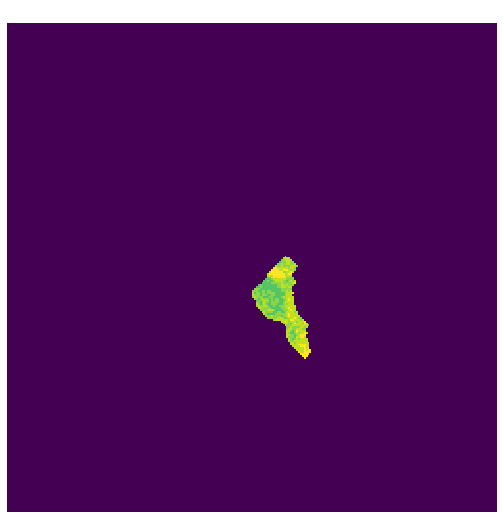

In [31]:
img_2d = file.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

#Skull Stripping
skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = dilasi)
brain_pixels = skull_stripped_image[dilasi == foreground_value]

# Adapting the data to K-means
kmeans_input = np.float32(brain_pixels.reshape(brain_pixels.shape[0], brain_pixels.ndim))

# K-means parameters
epsilon = 0.01
number_of_iterations = 50
number_of_clusters = 4
number_of_repetition = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,number_of_iterations, epsilon)
flags = cv2.KMEANS_RANDOM_CENTERS

# K-means segmentation
_, labels, centers = cv2.kmeans(kmeans_input, number_of_clusters, None, criteria,number_of_repetition, flags)

# Adapting the labels
labels = labels.flatten('F')
for x in range(number_of_clusters):
    labels[labels == x] = centers[x]

#segmented Image
segmented_image = np.zeros_like(dilasi)
segmented_image[dilasi == foreground_value] = labels
ShowImage('Segmented Image',segmented_image,'rgb')

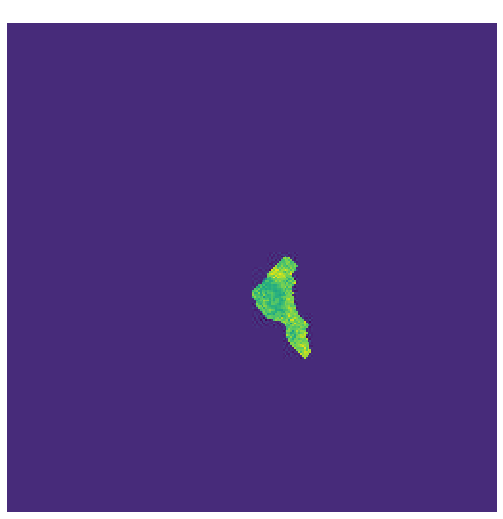

In [32]:
path = "C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\Simple_Brain_MRI_Segmentation\\experiment\\"
plt.imsave(path + "hasil_perc2.jpeg", segmented_image)
image = cv2.imread(path + "hasil_perc2.jpeg", 0)
ShowImage('ambil',image,'rgb')

# Active Contour
ini adalah fitur yang berfungsi untuk mencari nilai tertentu dari gambar mana yang ingin kita dapatkan gambarnya. salah satunya yaitu segmentasi otak ini. karena bersifat fitur. maka hanya sebatas ekstra dari hasil sebelumnya.

In [21]:
def circle_points(resolution, center, radius):
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    return np.array([c, r]).T

# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [140, 150], 50)[:-1]

def image_show(image, nrows=1, ncols=1, cmap='gray'): 
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 9)) 
    ax.imshow(image, cmap='gray') 
    ax.axis('off') 
    return fig, ax

In [22]:
fig, ax = image_show(segmented_image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

In [24]:
import skimage.color as color 
image_gray = color.rgb2gray(segmented_image) 
image_show(image_gray);

In [25]:
snake = seg.active_contour(image_gray, points,alpha=0.06,beta=0.3)
fig, ax = image_show(segmented_image)
# ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

In [0]:
# # Display
# captions = ["1. Original image", "2. Thresholding",
#             "3. Largest connected component + Mathematical morphology",
#             "4. Segmented image"]
# horizontal_layout = np.hstack(
#     (hasil, binarized, dilasi_close, segmented_image))
# cv2.imshow(" | ".join(captions), horizontal_layout)

# cv2.waitKey(0)

# Row All-in One
Munculkan semua gambar dalam 1 folder

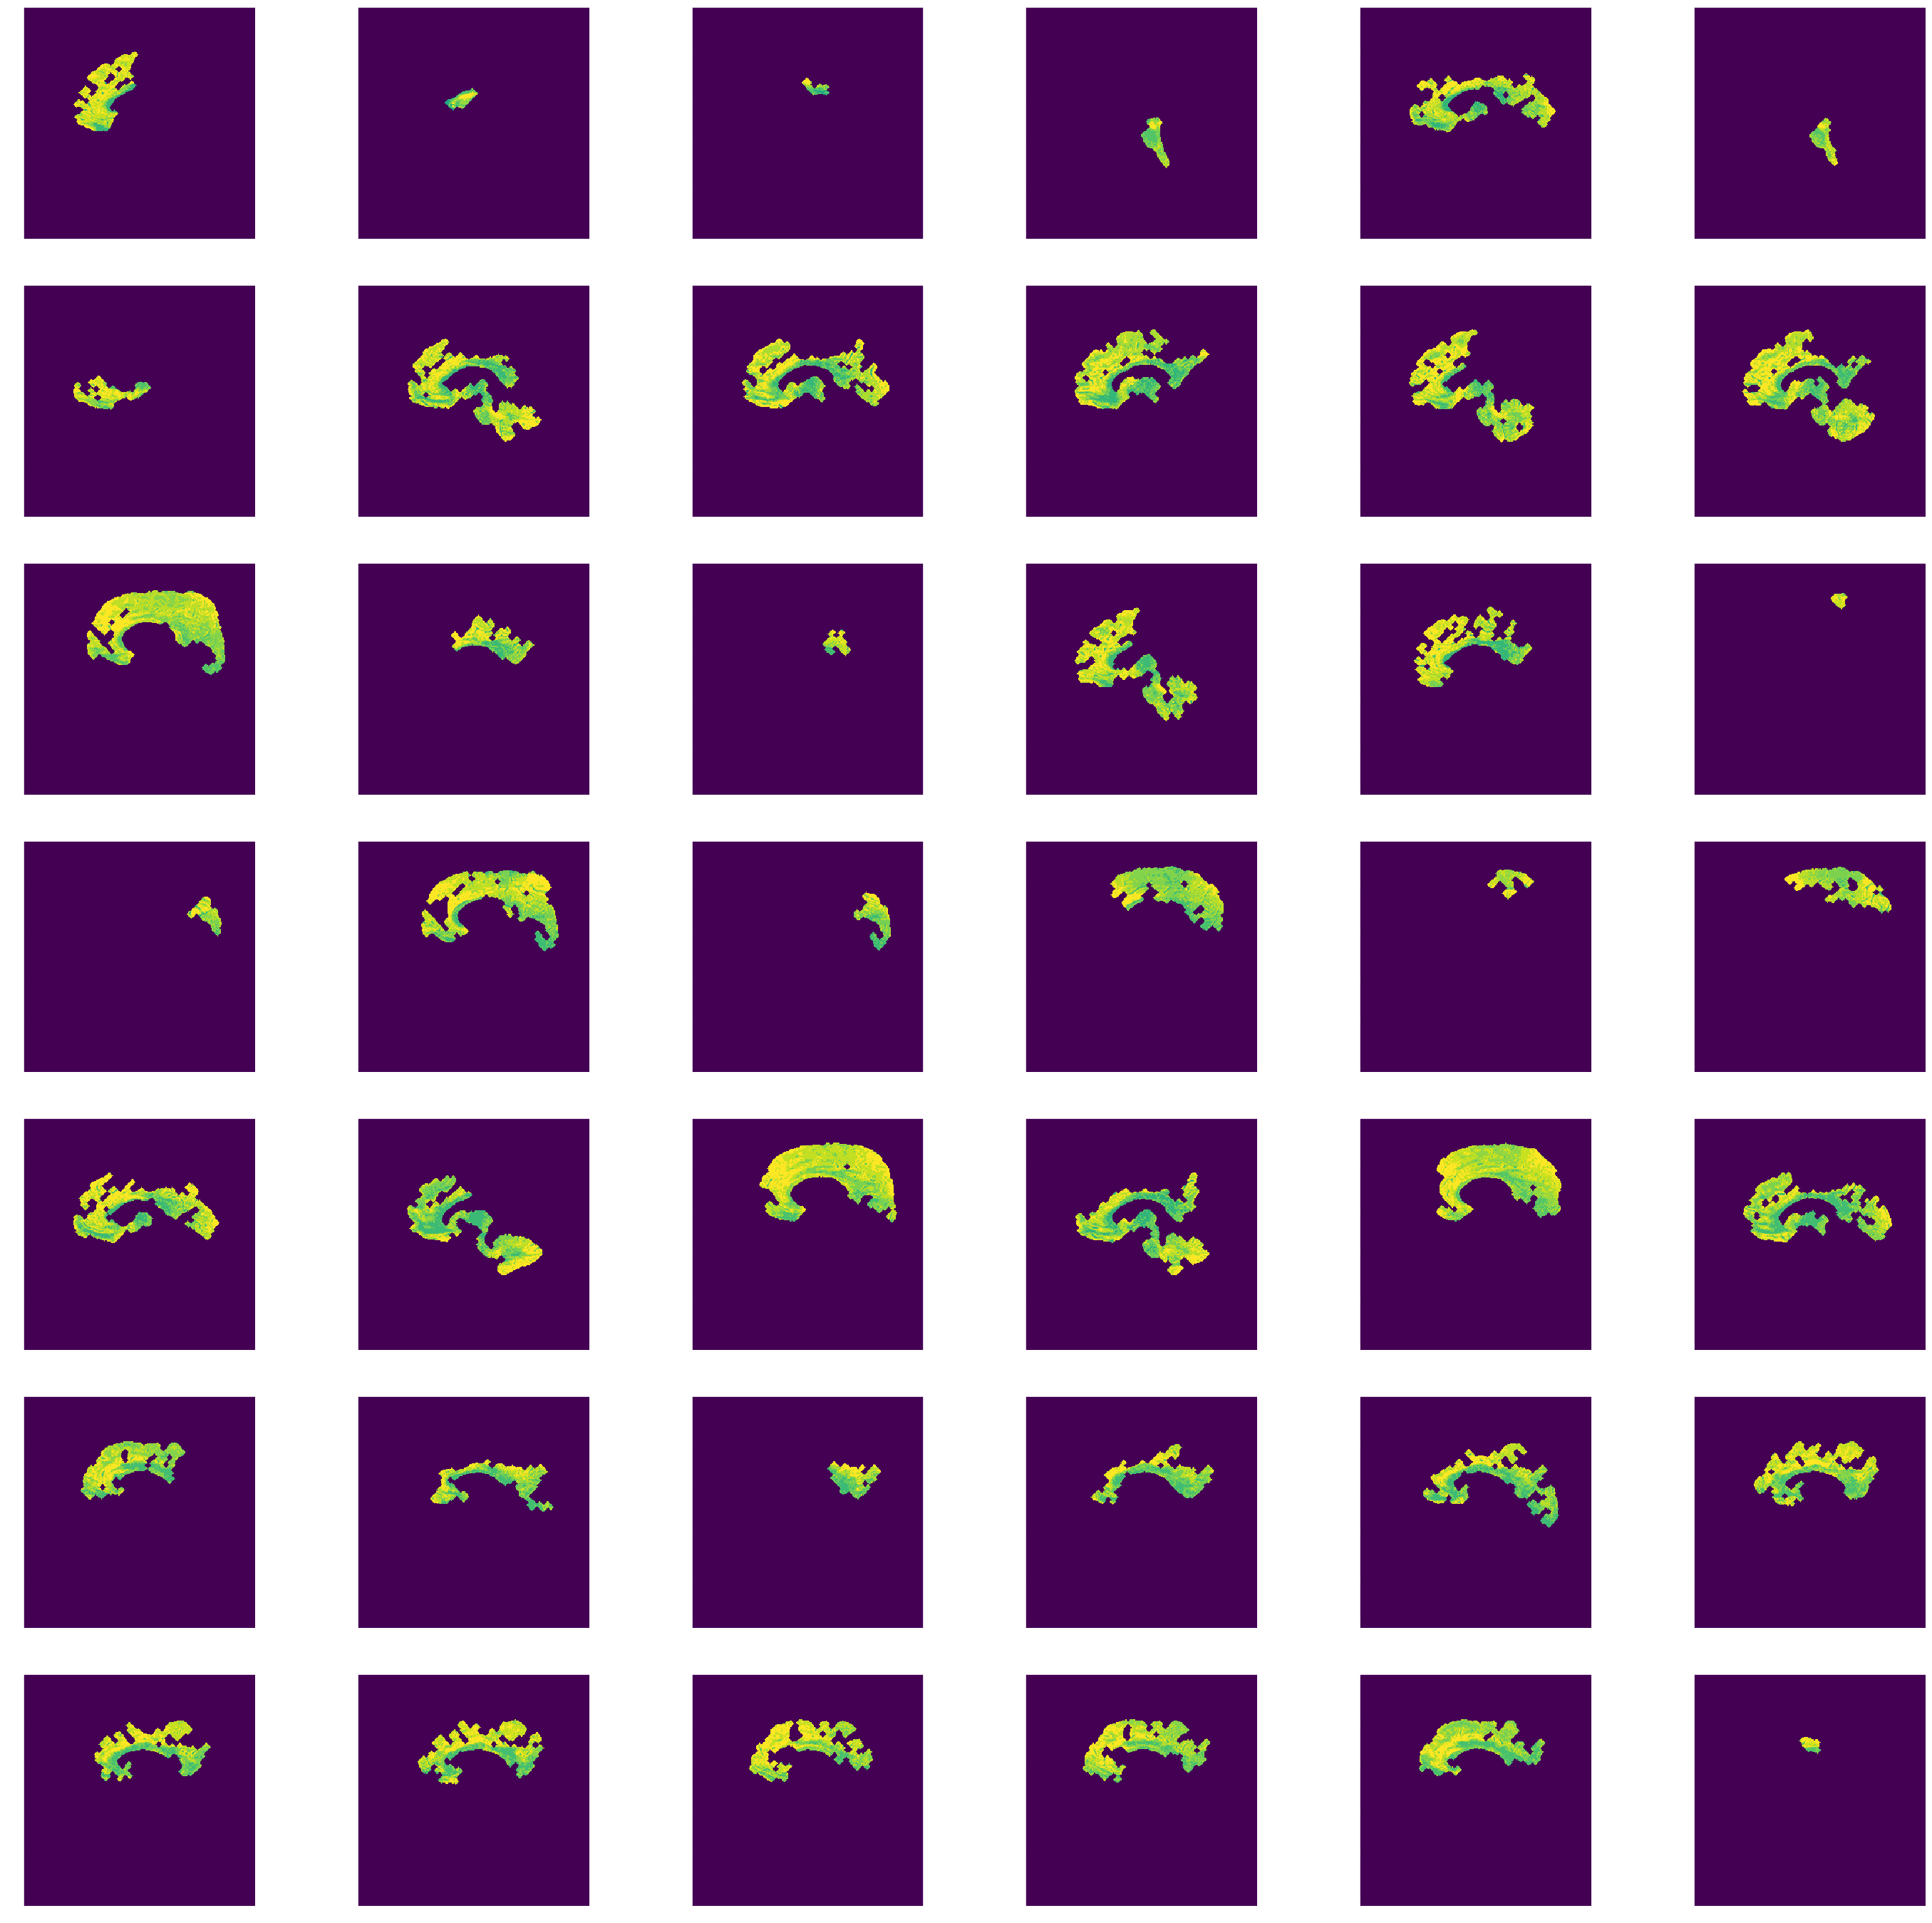

In [37]:
basepath ="C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\Simple_Brain_MRI_Segmentation\\dicom\\"
IMAGE_PATHS = os.listdir(basepath)

list_b = []
for f in IMAGE_PATHS:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    img_2d = a.astype(float)
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    img_2d_scaled = np.uint8(img_2d_scaled)
    hasil = img_2d_scaled

    #OTSU THRESHOLDING
    _,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    foreground_value = 255
    mask = np.uint8(binarized == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    binarized = np.zeros_like(binarized)
    binarized[labels == largest_label] = foreground_value

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    erosion = cv2.erode(binarized,kernel,iterations = 4)

    foreground_value = 255
    mask = np.uint8(erosion == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    erosion = np.zeros_like(erosion)
    erosion[labels == largest_label] = foreground_value

    opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel, iterations= 2)

    foreground_value = 255
    mask = np.uint8(opening == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    opening = np.zeros_like(opening)
    opening[labels == largest_label] = foreground_value

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilasi = cv2.dilate(opening,kernel,iterations = 1)

    foreground_value = 255
    mask = np.uint8(dilasi == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    dilasi = np.zeros_like(dilasi)
    dilasi[labels == largest_label] = foreground_value


    #Skull Stripping
    skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = dilasi)
    brain_pixels = skull_stripped_image[dilasi == foreground_value]

    # Adapting the data to K-means
    kmeans_input = np.float32(brain_pixels.reshape(brain_pixels.shape[0], brain_pixels.ndim))

    # K-means parameters
    epsilon = 0.01
    number_of_iterations = 50
    number_of_clusters = 4
    number_of_repetition = 10
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,number_of_iterations, epsilon)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # K-means segmentation
    _, labels, centers = cv2.kmeans(kmeans_input, number_of_clusters, None, criteria,number_of_repetition, flags)

    # Adapting the labels
    labels = labels.flatten('F')
    for x in range(number_of_clusters):
        labels[labels == x] = centers[x]

    #segmented Image
    segmented_image = np.zeros_like(dilasi)
    segmented_image[dilasi == foreground_value] = labels
    
    list_b.append(segmented_image)
    
fig=plt.figure(figsize=(49, 49))
columns = 6
rows = 7
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_b[i])
plt.show()